### Import Libraries

In [58]:
import numpy as np
import xarray as xr
import h5py 
import random

from sklearn import tree
import graphviz

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy


### Define Plotting Methods

In [59]:
def addSubplot(data, variable = None, lons = None, lats = None, time = 0, index = 0, size_x = 1, size_y = 1):
	if lons is None or lats is None:
		try:
			lons = data.variables['lon']
			lats = data.variables['lat']
		except Exception:
			print("Longitude/Lattide variables not found!")
			return
	extent = [lons.min(), lons.max(), lats.min(), lats.max()]
	ax = plt.subplot(size_x,size_y,index, projection=ccrs.PlateCarree())
	ax.set_extent(extent, crs=ccrs.PlateCarree())
	ax.coastlines(resolution='50m')
	ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
	ax.add_feature(cartopy.feature.RIVERS)	
	if variable == None:
		ax.contourf(lons, lats, data ,cmap = "jet")
	else:
		ax.contourf(lons, lats, data[variable][time],cmap = "jet")

        
        
def plotData(data, lons, lats):
	plt.figure(figsize=(12, 4))
	extent = [lons.min(), lons.max(), lats.min(), lats.max()]
	ax = plt.axes(projection=ccrs.PlateCarree())
	ax.set_extent(extent)
	ax.gridlines()
	ax.coastlines(resolution='50m')
	ax.add_feature(cartopy.feature.OCEAN)
	ax.add_feature(cartopy.feature.LAND, edgecolor='black')
	ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
	ax.add_feature(cartopy.feature.RIVERS)	
	ax.contourf(lons, lats, data, cmap = "jet")
	plt.show()

#### Define Functions for data extraction

In [60]:
def extractLearningData(data, labels, indeces, hour = 0): 
    input_data = []
    output_data = []
    for variable in data.variables:
         if "bt" in variable:
            masked_channel = np.array(data[variable])[hour,indeces[0],indeces[1]].flatten() 
            input_data.append(masked_channel)
    input_data = np.array(input_data)
    sp = input_data.shape
    input_data = input_data.flatten().reshape(sp[1],sp[0], order='F')
    
    output_data = np.array(labels["CT"])[hour,indeces[0], indeces[1]].flatten()
    return input_data, output_data


In [61]:
def cleanData(data, labels, indeces):
    counter = 0
    valid = np.ones(len(indeces[0]), dtype=bool)
    for i in range(len(indeces[0])):
        if np.isnan(labels[i]):
            valid[i] = False
            counter += 1
        elif np.isnan(data[i]).any():
            valid[i] = False
            counter += 1
    cleaned_indeces = np.array([indeces[0][valid], indeces[1][valid]])
    cleaned_data = data[valid,:]
    cleaned_labels = labels[valid]
    print("%i positions deleted for including nan-values." % counter)

    return cleaned_data, cleaned_labels, cleaned_indeces


##### Read trainig-data

In [62]:
data_directory = "../data/"
filename_labels = "nwcsaf_msevi-nawdex-20160925.nc"
filename_data = "msevi-nawdex-20160925.nc"
filename_mask = "region_masks_for_msevi_nawdex.h5"

sat_data = xr.open_dataset(data_directory+filename_data)
label_data = xr.open_dataset(data_directory+filename_labels)
mask_data = h5py.File(data_directory+filename_mask, 'r')

lons = sat_data['lon']
lats = sat_data['lat']




##### Convert mask to xr-Dataset

In [63]:
dims = ['rows', 'cols']
coords = {'lat': sat_data.coords['lat'], 'lon':sat_data.coords['lon']}

mask_ds = xr.Dataset()
for key in mask_data.keys():
	if key == "_source":
		continue
	m = xr.DataArray([row for row in mask_data[key]], dims = dims, coords = coords, name = key + "_mask")
	mask_ds[key + "_mask"] = m

    

##### create masked indices and discard those pointing to 'nan's

In [64]:
clean_indeces = np.where(mask_ds["mediterranean_mask"])
for i in range(24):
    a,b = extractLearningData(sat_data, label_data, clean_indeces, hour = i)
    #print(b.shape)
    _, _, clean_indeces = cleanData(a,b,clean_indeces)



1 positions deleted for including nan-values.
2 positions deleted for including nan-values.
1 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
5 positions deleted for including nan-values.
1 positions deleted for including 

##### Extract trainig samples and corresponding labels

In [78]:

n = 1000
# number of points from the mapped dataset choose for learning 
#(each point is sampled 24x, once for every timeframe)

# create a selection of 'n' index-pairs
selection = np.array(random.sample(list(zip(clean_indeces[0],clean_indeces[1])),n))
s = selection.shape
selection = selection.flatten().reshape(s[1],s[0],order = 'F')

training_data = np.empty([0,8])
training_labels = np.array([])
# get values for each selected point for each hour
for i in range(24):
    a,b = extractLearningData(sat_data, label_data,selection, hour = i)
    training_data = np.append(training_data, a, axis=0)
    training_labels = np.append(training_labels, b, axis=0)

training_data = np.array(training_data)
#print(training_data.shape)
#print(training_labels.shape)
    

##### Train classifier with selected data

In [79]:
cl = tree.DecisionTreeClassifier()
cl.fit(training_data, training_labels)

DecisionTreeClassifier()

##### Read test data

In [80]:
filename_testlabels = "nwcsaf_msevi-nawdex-20160920.nc"
filename_testdata = "msevi-nawdex-20160920.nc"
hour = 0

raw_test_data = xr.open_dataset(data_directory+filename_testdata)
raw_test_label = xr.open_dataset(data_directory+filename_testlabels)


test_indices = np.where(mask_ds["mediterranean_mask"])
test_data, test_labels = extractLearningData(raw_test_data, raw_test_label, test_indices, hour)
test_data, test_labels, test_indices = cleanData(test_data, test_labels, test_indices)


9 positions deleted for including nan-values.


#### Evaluate model

In [81]:
pred_labels = cl.predict(test_data)

correct = np.sum(pred_labels == test_labels)
total = len(pred_labels)
print("Correctly identified %i out of %i labels! \nPositve rate is: %f" % (correct, total, correct/total))

Correctly identified 125690 out of 171387 labels! 
Positve rate is: 0.733370


#### Return data-vectors into the shape of the original dataset

In [74]:
def imbedData(data, indices, shape, dims, coords, name):
    new_data = np.empty(shape)
    new_data[:] = np.nan
    
    new_data[indices[0],indices[1]] = data
    new_data = xr.DataArray(new_data, dims = dims, coords = coords, name = name)
    return new_data
    

In [75]:
dims = ['rows', 'cols']
coords = {'lat': sat_data.coords['lat'], 'lon':sat_data.coords['lon']}

pred_labels_imb = imbedData(pred_labels, test_indices, lons.shape, dims, coords, "predicted_labels")
test_labels_imb = imbedData(test_labels, test_indices, lons.shape, dims, coords, "real_labels")

lats_masked = lats.where(mask_ds["mediterranean_mask"])
lons_masked = lons.where(mask_ds["mediterranean_mask"])


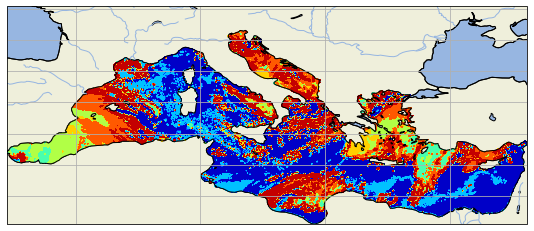

In [76]:
plotData(pred_labels_imb, lons_masked, lats_masked)

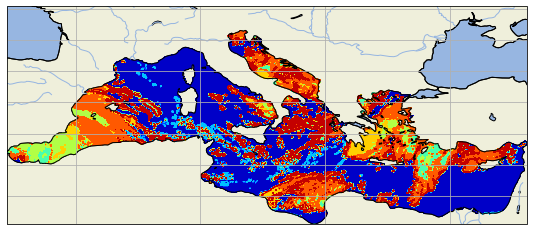

In [77]:
plotData(test_labels_imb, lons_masked, lats_masked)

### test stuff and such

NameError: name 'mapped_indeces' is not defined

In [ ]:
a,b = extractLearningData(sat_data, label_data, mapped_indeces)
print(a.shape)
print(b.shape)
print(mapped_indeces[0].shape)

clean_data, clean_labels,clean_indeces = cleanData(a,b,mapped_indeces)
print(clean_labels.shape)

In [ ]:
a = np.array([[1,2,3,4,5],[9,8,9,7,9], [11,11,11,11,11]])
a.flatten().reshape((5,3), order='F')